# Convolutional Autoencoder for embedding

## Overview
* [Introduction](#intro)
* [Classifier](#Classsification)
* [Convolutional autoencoder](#Autoencoder)
* [Comparing embeddings](#Embeddings)
    - T-SNE
    - K nearest neighbour
* [Conclusion](#Conclusion)

### Introduction <a class="anchor" id="intro">

The subject for this notebook is to look into how autoencoders can be used with convolutional neural networks to create embeddings for images. Embedding layers is very useful when dealing with categorical features or in this case images. Suppose you are interested in how well pieces of clothes look alike this can be done on pixel level but the issue with this is that images typically consist of many pixels and instead if it was possible to make an embedding of the picture such that embedding extract the most important features in the picture. Think of a picture of a t-shirt if it is possible to make an embedding that extract which color it has, what kind of shape it has and if the t-shirt has printing on the embedding can be used to see what other t-shirts looks the same or the embedding could be used in a recommendation system to characterize pieces of clothes a particular customer likes. One of the benefits of using autoencoder is that an autoencoder tries to recreate the input and are in essence an unsupervised method the benefit of this is that you do not rely on having labeled dataset which can be a nuisance to collect. The embedding then comes from subsetting the autoencoder an using this as an embedding. The supervised version of this would be to have label for each picture that clarifies the class of the images and fit a classfier on the problem and subsetting that to achieve an embedding for the images. 

The data used for this notebook is the MNIST-fashion data courtesy of [Zalando Research](https://github.com/zalandoresearch/fashion-mnist). The dataset is a spin on the famous MNIST dataset of handwritten numbers instead the MNIST-fashion consist of 60000 training images and 10000 test images of pieces of clothes in 10 different categories (T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot). Even though the images is of very low resolution (28x28)-pixels and in grayscale it is sufficient to get a sense of how these type of models would work.
  
To see how good the two embeddings perform T-SNE and K-nearest neighbour is used. T-SNE is used to convert the embedding space into 2-dimensions to visualize how well the classes gets clustered the better the classes are separated the better the embedding. Furthermore to see how well the embeddings are at suggesting familiar images K-nearest neighbour method is used on a subset of the images to see which images look the most familiar to the original.  


## Package import and downloading data

In [1]:
import numpy as np 
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from keras.utils.np_utils import to_categorical
from keras.datasets import fashion_mnist

from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, UpSampling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

#from numba import cuda

import tensorflow as tf

Using TensorFlow backend.


In [2]:
## Function to time code.
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


In [4]:
## Download images
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train, x_test = x_train/255, x_test/255

y_train_dummy = to_categorical(y_train)
y_test_dummy = to_categorical(y_test)

label_dict = {0: 'T-shirt/top',
            1: 'Trouser',
            2: 'Pullover',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandal',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Ankle boot'}

## Quick visualization

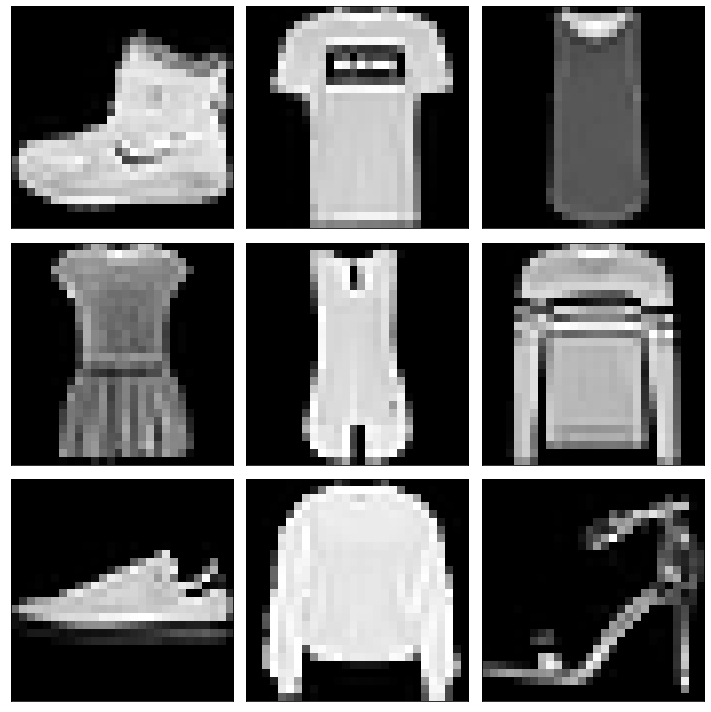

In [5]:
## Display some examples
fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize=(10,10))
cnt = 0

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(x_train[cnt,:,:], cmap='gray')
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].get_yaxis().set_visible(False)
        
        cnt = cnt + 1
fig.tight_layout()

## Classifier <a class='anchor' id='Classification'>
    
First lets take a look at the classifier. For the classification problem a combination of convolutional neural network with kernel size of 3x3, relu as activation functions and fully connected layers with relu and l2 regularization are used ending in a softmax layer. The last layer (softmax layer) will represent the probability of that the image going through the network belongs to one of the 10 separate classes. The classifier is trained using the Adam optimizer with categorical crossentropy loss function and 20% set aside for validation. Furthermore checkpoints is made throughout the training of the model saving only the best model based on the accuracy on the validation set. I've used this exact model on the original MNIST with great results so hopefully this wil generalize quite well. An overview of this model can be found under Diagrams.

In [6]:
## Embedding using supervised learning
def build_classifier(lr, l2_reg):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))  
    model.add(BatchNormalization())
              
    model.add(Flatten())
    
    model.add(Dense(units=4048, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(units=4048, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(units=1000, activation='relu', kernel_regularizer=l2(l2_reg)))
              
    model.add(Dense(units=10, activation='softmax'))
    
    model.compile(optimizer=Adam(lr=lr),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [7]:
## Building the model
classification_model = build_classifier(lr=0.001, l2_reg=0.01)
classification_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         2

In [ ]:
## Setup model checkpoint and training.
checkpoint_path = 'output/training/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

mcp = ModelCheckpoint(checkpoint_path, 
                      monitor='val_accuracy', 
                      mode='max', 
                      save_best_only=True,
                      save_weights_only=True)

classification_history = classification_model.fit(x_train.reshape(x_train.shape[0], 28, 28,1), 
                          y_train_dummy,
                          epochs=100,
                          validation_split=0.2,
                          batch_size=256,
                          verbose=2,
                          callbacks=[mcp]
                          )

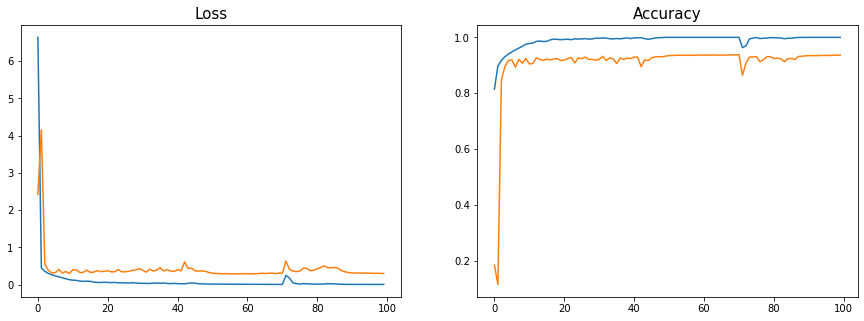

In [9]:
fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].plot(classification_history.history['loss'], label='Training')
ax[0].plot(classification_history.history['val_loss'], label='Validation')
ax[0].set_title('Loss', fontsize=15)

ax[1].plot(classification_history.history['accuracy'], label='Training')
ax[1].plot(classification_history.history['val_accuracy'], label='Validation')
ax[1].set_title('Accuracy', fontsize=15);

In [99]:
classification_model.load_weights('output/training/cp.ckpt')
classification_model.save('output/trainedModel/CNN_model.h5')

In [100]:
classification_model.evaluate(x_test.reshape(x_test.shape[0], 28, 28,1), 
                              y_test_dummy,
                              batch_size=256, 
                              verbose=2)

10000/1 - 1s - loss: 0.2075 - accuracy: 0.9302


[0.3439085891008377, 0.9302]

The model seems to have converged after only 100 epochs and achieves around 93% accuracy on the test data. To achieve better performance one should consider the generalization error since the model gets a rather good accuracy on the training data. Looking at the loss as a function of the epochs there seems to be a overfitting that happens already after 20 epochs. However for the purpose of this notebook this performance will suffice. Recall that during training checkpoints is made and the best possible model based on validation accuracy is used and this is the weights that will be used in the embedding comparison further below.

## Convolutional autoencoder <a class='anchor' id='Autoencoder'>

Autoencoder is a type of neural networks that tries to obtain efficient encodings in a unsupervised fashion. The features of the autoencoder is also used as the response in the training phase giving that the model based on the input will try to replicate the input for the output. One of the great advantages with the autoencoder is that it is unsupervised so if the dataset is without labels or labeling is very expensive this type of learning can still produce very good results. In this work the autoencoder will be used as a way to obtain a meaningful embedding for the images the embedding can then be used for multiple things such as a recommender system, a similarity analysis of or as a embedding layer for another neural network.

The encoding part of the autoencoder is similar to the classifier and the decoder is just the opposite of the encoder with upscaling layers instead for maxpooling layers resulting in an output layer that is the same size as the input layer a diagram of this model is available under diagrams. The decoder ends in a convolutional layer with sigmoid activation function. The model is compiled using Adam optimizer and mean abosolute error. 

In [5]:
def build_convolutional_autoencoder(lr):
    input_img = Input((28,28,1))

    ## Encoding
    encoding_conv_1 = Conv2D(filters=64, 
                             kernel_size=(3,3), 
                             padding='same', 
                             activation='relu')(input_img)
    
    encoding_batchnorm_1 = BatchNormalization()(encoding_conv_1)
    
    encoding_maxpool_1 = MaxPooling2D(pool_size=(2,2))(encoding_batchnorm_1)

    encoding_conv_2 = Conv2D(filters=128, 
                             kernel_size=(3,3), 
                             padding='same', 
                             activation='relu')(encoding_maxpool_1)
    
    encoding_batchnorm_2 = BatchNormalization()(encoding_conv_2)
    
    encoding_maxpool_2 = MaxPooling2D(pool_size=(2,2))(encoding_batchnorm_2)

    encoding_conv_3 = Conv2D(filters=256, 
                             kernel_size=(3,3), 
                             padding='same',
                             activation='relu')(encoding_maxpool_2)
    
    encoding_batchnorm_3 = BatchNormalization()(encoding_conv_3)
    
    encoding_maxpool_3 = MaxPooling2D(pool_size=(2,2), padding='same')(encoding_batchnorm_3)

    encoding_conv_4 = Conv2D(filters=512, 
                             kernel_size=(3,3),
                             padding='same', 
                             activation='relu')(encoding_maxpool_3)
    
    encoding_conv_41 = Conv2D(filters=512, 
                             kernel_size=(3,3),
                             padding='same', 
                             activation='relu')(encoding_conv_4)
    
    encoding_batchnorm_4 = BatchNormalization()(encoding_conv_41)
    
    encoding_maxpool_4 = MaxPooling2D(pool_size=(4,4))(encoding_batchnorm_4)

    ## Decoding 
    decoding_conv_1 = Conv2D(filters=512,
                             kernel_size=(3,3),
                             padding='same',
                             activation='relu')(encoding_maxpool_4)
    
    decoding_conv_11 = Conv2D(filters=512,
                             kernel_size=(3,3),
                             padding='same',
                             activation='relu')(decoding_conv_1)
    
    deconding_batchnorm_1 = BatchNormalization()(decoding_conv_11)
    
    decoding_upscale_1 = UpSampling2D(size=(4,4))(deconding_batchnorm_1)

    decoding_conv_2 = Conv2D(filters=256,
                             kernel_size=(3,3),
                             padding='same',
                             activation='relu')(decoding_upscale_1)
    
    deconding_batchnorm_2 = BatchNormalization()(decoding_conv_2)
    
    decoding_upscale_2 = UpSampling2D(size=(2,2))(deconding_batchnorm_2)

    decoding_conv_3 = Conv2D(filters=128, 
                             kernel_size=(3,3),
                             padding='same',
                             activation='relu')(decoding_upscale_2)
    
    deconding_batchnorm_3 = BatchNormalization()(decoding_conv_3)
    
    decoding_upscale_3 = UpSampling2D(size=(2,2))(deconding_batchnorm_3)

    decoding_conv_4 = Conv2D(filters=64,
                             kernel_size=(3,3),
                             activation='relu',)(decoding_upscale_3)
    
    deconding_batchnorm_4 = BatchNormalization()(decoding_conv_4)
    
    decoding_upscale_4 = UpSampling2D(size=(2,2))(deconding_batchnorm_4)

    ## output 
    output_img = Conv2D(filters=1, 
                        kernel_size=(3, 3),
                        activation='sigmoid',
                        padding='same')(decoding_upscale_4)

    model = Model(input_img, output_img)

    model.compile(optimizer=Adam(lr),
                  loss='mean_absolute_error')

    return model
    
cae_model = build_convolutional_autoencoder(0.1)

cae_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0     

In [ ]:
tic()
cae_model = build_model(0.01)
cae_history = cae_model.fit(x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1),
                            x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1),
                            epochs=1000,
                            validation_split=0.2,
                            shuffle=True,
                            batch_size=128,
                            verbose=2)
toc()

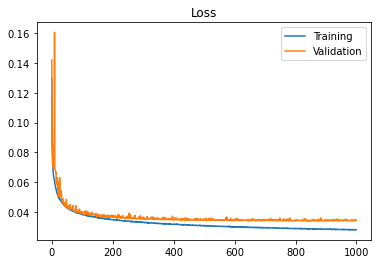

In [11]:
plt.plot(cae_history.history['loss'], label='Training')
plt.plot(cae_history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss')
plt.show()

Looking at the loss function the model achieves looks to generalize very well on the validation set and seems to have converged quite well. Another way to see how good the model is to send the test data through the model and see how well the replicated images looks to the original. 

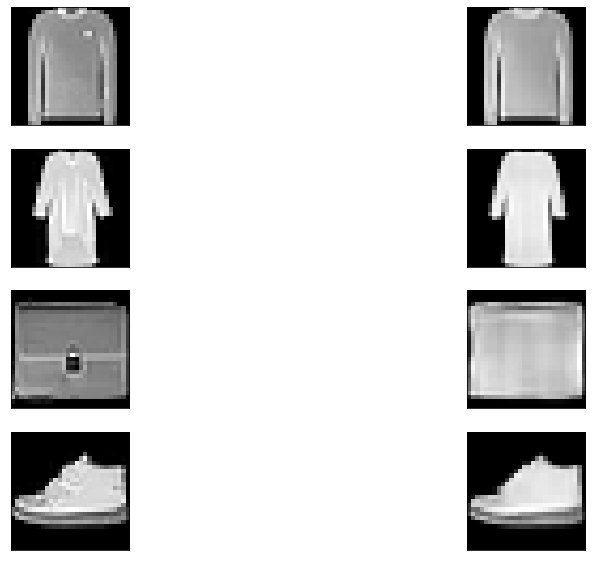

In [12]:
output = cae_model.predict(x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1), batch_size=128)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,10))
cnt = 0
random_images = np.random.randint(10000, size=4)

for i in range(4):
    ax[i][0].imshow(x_test[random_images[cnt]], cmap='gray')
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    
    ax[i][1].imshow(output[random_images[cnt],:,:,0], cmap='gray')
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)
    
    cnt += 1

Looking at the replicated images the model seems to capture the shape and some of the textures on the piece of clothe however it does not catch exactly the texture of the piece of clothe good example is the bag that have some kind of button but the replicated image does not. If the model were to be improved one could look to increase the complexity of the model, and maybe try different kernel size for the convolutional layers. For the sake of this notebook the model here will suffice to see if it is possible to achieve an meaningful embedding layer compared to the supervised case (the classifier).

In [14]:
cae_model.save('output/trainedModel/CAE_model.h5')

## Comparing embeddings <a class='anchor' id='Embeddings'>

An embedding is a function that maps from the original space to what we will call the embedding space. The embedding space is a n-dimensional representation of the original space objects that is similar to each other will be close to each other in the embedding using a distance measure. The embedding space can be of the same dimension as the original space or smaller to make the embedding more "efficient". Embeddings is typically used with categorical features especially there is a lot of categories. One way of using categorical features in models is to use dummy variables but if there is a lot of categories the dimension of each observation can increase very rapidly, an embedding layer in this case will much more efficient.

Here the goal is to obtain an embedding for clothes with will encompass the main features of a piece of clothes to use later. The two embeddings obtained from the classifier and the autoencoder is compared to see if the unsupervised embedding is useful. 

In [8]:
classification_model = load_model('output/trainedModel/CNN_model.h5')

classifcation_embedding_model = Sequential()

for layer in classification_model.layers[:-4]:
    classifcation_embedding_model.add(layer)

classification_embedding = classifcation_embedding_model.predict(x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1), batch_size=256)

In [9]:
cae_model = load_model('output/trainedModel/CAE_model.h5')

cae_embedding_model = Sequential()

for layer in cae_model.layers[:-13]:
    cae_embedding_model.add(layer)

cae_embedding_model.add(Flatten())

cae_embedding = cae_embedding_model.predict(x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1), batch_size=128)

### t-SNE - comparison

The t-SNE(t-distributed stochastic neighbor embedding) is a non linear dimensionality reduction methos typically used for visualization. T-SNE constructs a probability distribution over pairs in the high-dimensional space. This is constructed in a way such that objects that is close to each other will have higher probability. Similarly this is done in the low-dimensional space and then the method minimizes the KL divergence. Here the low dimension is 2-dimensions since this is easy visualize doing this will of course lose some of the nuances the high dimension provides. 

The expectation is that if the embedding is performing well there will be a clear separation of the 10 different classes. This will of course not visualize how well striped items lookalike but only classes. 

In [21]:
## T-SNE for the classification model
tsne_classification = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_classification_results = tsne_classification.fit_transform(classification_embedding)

df_class = pd.DataFrame()

df_class['tsne-1d'] = tsne_classification_results[:,0]
df_class['tsne-2d'] = tsne_classification_results[:,1]
df_class['y-labels'] = [label_dict[x] for x in y_test]

## Similarily for the convolutional autoencoder
tsne_cae = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_cae_results = tsne_cae.fit_transform(cae_embedding)

df_cae = pd.DataFrame()

df_cae['tsne-1d'] = tsne_cae_results[:,0]
df_cae['tsne-2d'] = tsne_cae_results[:,1]
df_cae['y-labels'] = [label_dict[x] for x in y_test]

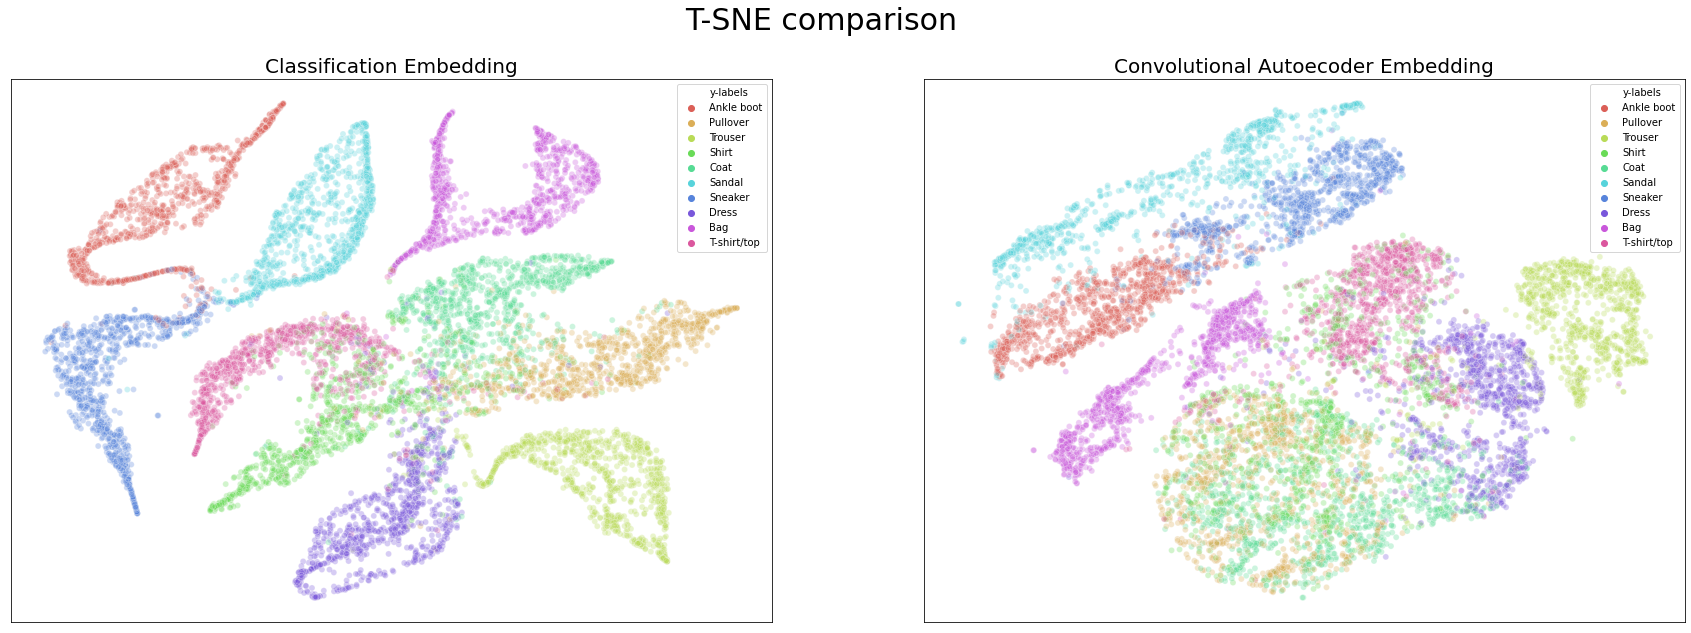

In [22]:
## Plotting the results of the T-SNE
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
fig.suptitle('T-SNE comparison', fontsize=30)

ax[0].set_title('Classification Embedding', fontsize=20)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].set_title('Convolutional Autoecoder Embedding', fontsize=20)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)


sns.scatterplot(
    x="tsne-1d", y="tsne-2d",
    hue="y-labels",
    palette=sns.color_palette("hls", 10),
    data=df_class,
    legend="full",
    alpha=0.3,
    ax=ax[0])

sns.scatterplot(
    x="tsne-1d", y="tsne-2d",
    hue="y-labels",
    palette=sns.color_palette("hls", 10),
    data=df_cae,
    legend="full",
    alpha=0.3,
    ax=ax[1]);

The embedding from the classifier performs very well dividing the classes clearly opposed to the embedding from the autoencoder. This is to be expected because the entire purpose of the classifier is to figure out which classes the image belongs to. However the autoencoder does seem to separate the classes not entirely but it definitely learns something about which class each of the images belongs to. 

### K Nearest Neighbours

K-nearest neighbours is a unsupervised machine learning algorithm that looks at the distance between objects and returns k number of objects that is close to the original object. To determine how well the embedding is the 3 nearest neighbour of 5 randomly chosen images is visualized to see how well the images look a like.

In [75]:
## K-nearest set-up
k = 4
no_img_shown = 5

image_no = np.random.randint(10000, size=no_img_shown)

In [76]:
classification_Knearest = NearestNeighbors(n_neighbors=k, radius=0.4)
classification_Knearest.fit(classification_embedding)
class_neighbours = classification_Knearest.kneighbors(classification_embedding, return_distance=False)

cae_Knearest = NearestNeighbors(n_neighbors=k, radius=0.4)
cae_Knearest.fit(cae_embedding)
cae_neighbours = cae_Knearest.kneighbors(cae_embedding, return_distance=False)

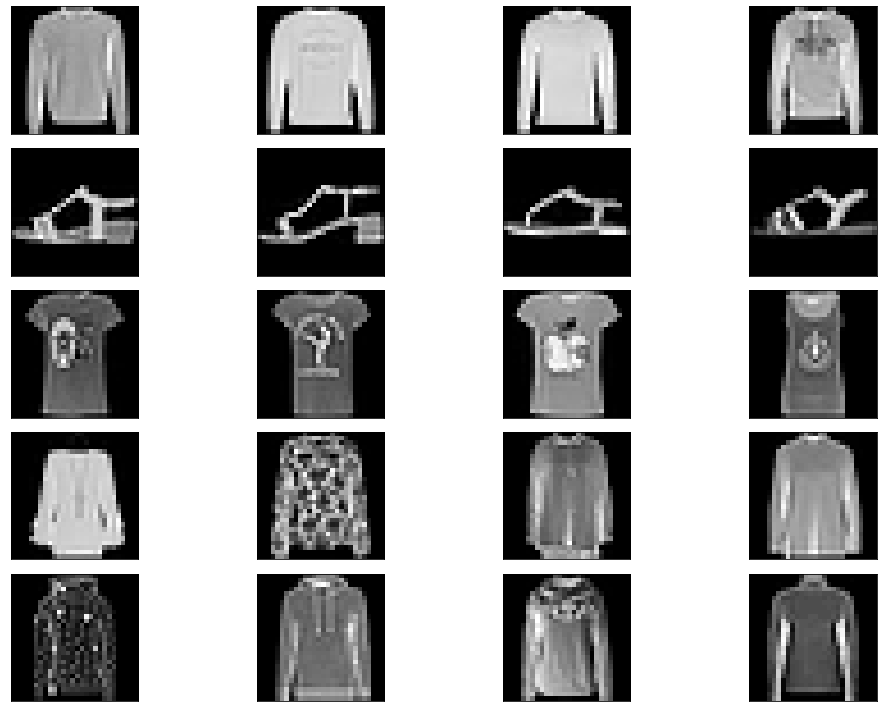

In [77]:
fig, ax = plt.subplots(nrows=no_img_shown, ncols=k, figsize=(15,10))
cnt = 0
    
for i in range(no_img_shown):
    for j in range(k):
        ax[i][j].imshow(x_test[class_neighbours[image_no[cnt]][j]], cmap='gray')
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].get_yaxis().set_visible(False)
    
    cnt += 1

fig.tight_layout()

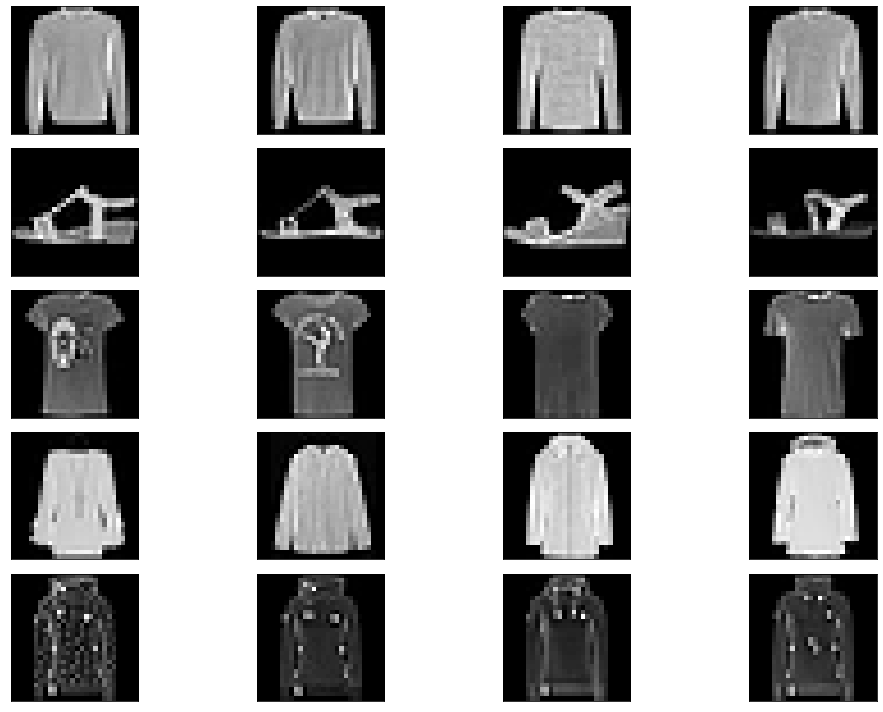

In [78]:
fig, ax = plt.subplots(nrows=no_img_shown, ncols=k, figsize=(15,10))
cnt = 0

for i in range(no_img_shown):
    for j in range(k):
        ax[i][j].imshow(x_test[cae_neighbours[image_no[cnt]][j]], cmap='gray')
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].get_yaxis().set_visible(False)
    
    cnt += 1

fig.tight_layout()

In [85]:
total = 0
for i in range(class_neighbours.shape[0]):
    total = total + (len(set(np.append(class_neighbours[i], cae_neighbours[i]))) - 1)
    
(((k*2-1)*10000) - total)/((k*2-1)*10000)

0.16367142857142858

Looking at k-nearest neighbours from the two embeddings both embeddings do seem to provide images that look similarly to the original image. The autoencoder seem to actually captures textures a little better that the classifier looking at the last two images. This could be because to classify the image it is not relevant if it has stripes or dots but merely what kind of shape the object is. Comparing the k-nearest neighbour for the whole test set the two embeddings only "agree" in 16% cases. This is calculated by looking at which images is provided by the k-nearest neighbour method for each of the test images and for each of the embeddings and the calculate the percentage of how many of the images from the k-nearest neighbour method is the same. 

## Conclusion <a class='anchor' id='Conclusion'>

Both the classifier and the autoencoder provided meaningful embeddings and especially the autoencoder showed good performance in terms of capturing textures of the clothes. One of the main reasons for looking into autoencoder embeddings is that this method is unsupervised meaning that it is not necessary to known anything about the image to obtain a good embedding you just need the image. This is very useful since labeling data can be very expensive.

To increase performace of the embeddings i would start looking a some hyperparameter optimization for the two neural networws and maybe play little bit more around with the layouts of the two models. Especially when looking at the output of the test set of the autoencoder the replicated images does not look exactly like the original which suggest that there still is somethings the model does not learn about. However I do think that the results achieved here would suggest that if you do not have labeled data the autoencoder would be a very good way to achieve an embedding, and even if you do have labeled you still ought to look into if autoencoder would be a suitable model for your problem of course depending on how your data is labeled. 